In [34]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Настройка стиля графиков
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Указываем, что код модульный и структурированный 
def load_and_clean_data(filepath):
    """
    Загружает данные, удаляет дубликаты, вратарей и игроков без матчей.
    """
    df = pd.read_csv(filepath)
    
    # Удаляем дубликаты
    df = df.drop_duplicates()
    
    # Преобразуем Appearances в числа (на всякий случай)
    df['Appearances'] = pd.to_numeric(df['Appearances'], errors='coerce')
    
    # 1. Удаляем Вратарей (слишком легкий класс)
    df = df[df['Position'] != 'Goalkeeper']
    
    # 2. Удаляем игроков, которые не сыграли ни одного матча (шум)
    # Это решает проблему деления на ноль и пустых строк (как у Галлахера)
    df = df[df['Appearances'] > 10]
    
    return df

print("Библиотеки загружены.")

Библиотеки загружены.


In [35]:
# Загрузка датасета
file_path = 'dataset - 2020-09-24.csv' 
df = load_and_clean_data(file_path)

print(f"Размер датасета после удаления вратарей: {df.shape}")
display(df.head())

# Проверка на пропущенные значения [cite: 37]
print("\nПропущенные значения:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Размер датасета после удаления вратарей: (363, 59)


,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Punches,High Claims,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides
3,Héctor Bellerín,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,...,NaN,NaN,NaN,NaN,NaN,NaN,23,0,125,8.0
4,Kieran Tierney,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2,0,9,0.0
6,Sokratis,5.0,Arsenal,Defender,Greece,32.0,44,21,11,3,...,NaN,NaN,NaN,NaN,NaN,NaN,18,0,56,1.0
7,Rob Holding,16.0,Arsenal,Defender,England,25.0,41,25,9,0,...,NaN,NaN,NaN,NaN,NaN,NaN,8,0,32,0.0
8,Shkodran Mustafi,20.0,Arsenal,Defender,Germany,28.0,99,52,26,7,...,NaN,NaN,NaN,NaN,NaN,NaN,28,0,117,7.0



Пропущенные значения:
Goals per match           127
Penalties scored          127
Freekicks scored          127
Shots                     127
Shots on target           127
Shooting accuracy %       127
Big chances missed        127
Clean sheets              236
Goals conceded            236
Tackle success %           92
Last man tackles          236
Clearances off line       236
Recoveries                 92
Duels won                  92
Duels lost                 92
Successful 50/50s          92
Aerial battles won         92
Aerial battles lost        92
Own goals                 236
Errors leading to goal     92
Cross accuracy %           92
Through balls              92
Accurate long balls        92
Saves                     363
Penalties saved           363
Punches                   363
High Claims               363
Catches                   363
Sweeper clearances        363
Throw outs                363
Goal Kicks                363
dtype: int64


In [36]:
def create_per_match_features(df):
    """
    Создает новые признаки, деля абсолютные значения на количество матчей (Appearances).
    Это устраняет смещение в сторону ветеранов АПЛ. 
    """
    df_eng = df.copy()
    
    # Список колонок, которые нужно нормализовать
    # Мы не берем возраст или уже процентные значения
    cols_to_normalize = [
        'Goals', 'Assists', 'Passes', 'Crosses', 'Tackles', 
        'Blocked shots', 'Interceptions', 'Clearances', 'Fouls', 
        'Yellow cards', 'Red cards', 'Shots', 'Hit wood work'
    ]
    
    # Проверка, существуют ли колонки в датасете
    existing_cols = [c for c in cols_to_normalize if c in df_eng.columns]
    
    for col in existing_cols:
        new_col_name = f"{col}_per_match"
        # Избегаем деления на ноль (хотя Appearances > 0, но для надежности)
        df_eng[new_col_name] = df_eng[col] / df_eng['Appearances']
        # Удаляем игроков, которые не сыграли ни одного матча

    
    return df_eng

# Применяем функцию
df_processed = create_per_match_features(df)

# Оставляем только нужные колонки для модели (убираем имена и сырые суммы)
features_to_keep = [col for col in df_processed.columns if '_per_match' in col] + ['Age', 'Position', 'Name']
df_model = df_processed[features_to_keep].copy()
df_model = df_model.fillna(0)

print("Feature Engineering завершен. Новые признаки созданы.")
display(df_model.head(3))

Feature Engineering завершен. Новые признаки созданы.


,Goals_per_match,Assists_per_match,Passes_per_match,Crosses_per_match,Tackles_per_match,Blocked shots_per_match,Interceptions_per_match,Clearances_per_match,Fouls_per_match,Yellow cards_per_match,Red cards_per_match,Shots_per_match,Age,Position,Name
3,0.043750,0.112500,44.531250,2.431250,1.337500,0.200000,1.300000,1.900000,0.781250,0.143750,0.0,0.0,25.0,Defender,Héctor Bellerín
4,0.062500,0.062500,32.437500,2.812500,1.312500,0.062500,0.750000,2.000000,0.562500,0.125000,0.0,0.0,23.0,Defender,Kieran Tierney
6,0.068182,0.045455,54.909091,0.022727,1.522727,0.090909,0.977273,3.977273,1.272727,0.409091,0.0,0.0,32.0,Defender,Sokratis


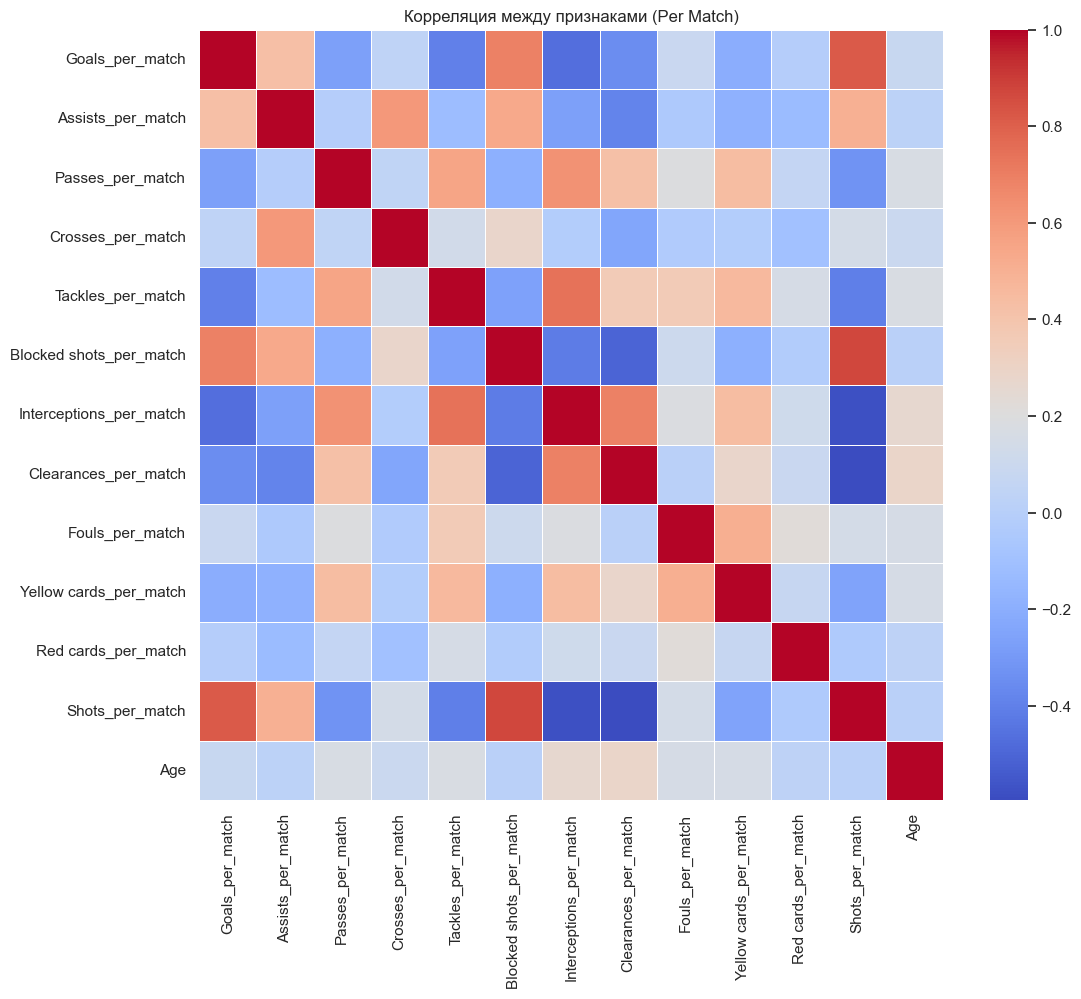

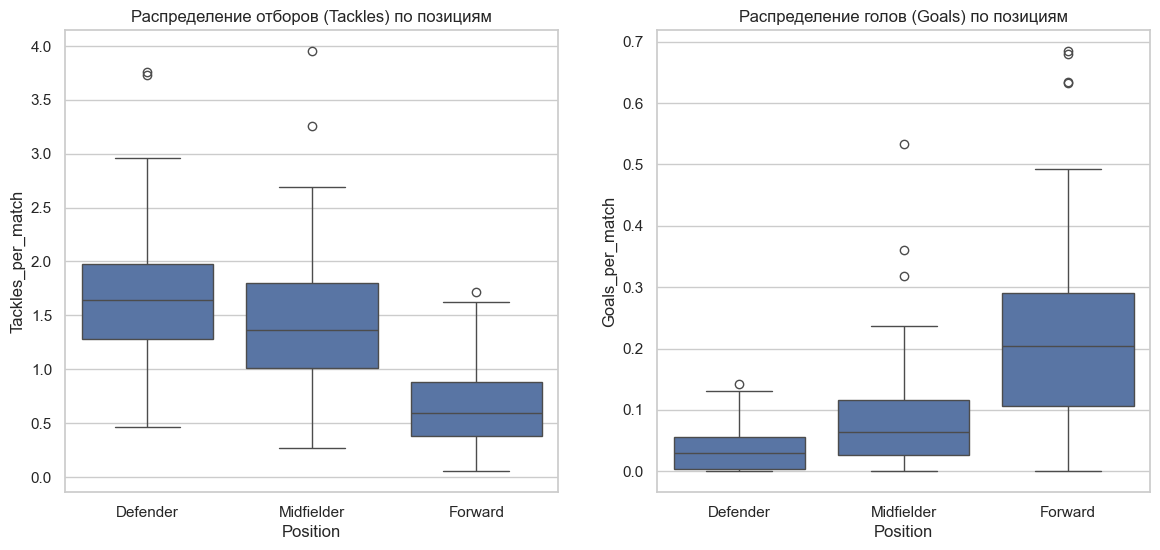

Инсайт: Защитники делают значительно больше отборов, но почти не забивают. Полузащитники находятся посередине.


In [37]:
# 1. Корреляционная матрица
plt.figure(figsize=(12, 10))
# Выбираем только числовые колонки для корреляции
numeric_cols = df_model.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Корреляция между признаками (Per Match)")
plt.show()

# 2. Распределение ключевых признаков по позициям
# Показывает, отличается ли поведение защитников и нападающих
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=df_model, x='Position', y='Tackles_per_match', ax=axes[0])
axes[0].set_title('Распределение отборов (Tackles) по позициям')

sns.boxplot(data=df_model, x='Position', y='Goals_per_match', ax=axes[1])
axes[1].set_title('Распределение голов (Goals) по позициям')

plt.show()

print("Инсайт: Защитники делают значительно больше отборов, но почти не забивают. Полузащитники находятся посередине.")

In [38]:
# Разделение на X и y
X = df_model.drop(['Position', 'Name'], axis=1) # Имена убираем из обучения
y = df_model['Position']

# Кодирование целевой переменной (Defender, Midfielder, Forward -> 0, 1, 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Разделение на Train и Test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

# Масштабирование данных (важно для линейных моделей) 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Данные разделены и отмасштабированы.")

Данные разделены и отмасштабированы.


In [39]:
# 1. Логистическая регрессия (Базовая модель для интерпретации)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("=== Logistic Regression Results ===")
print(classification_report(y_test, y_pred_log, target_names=le.classes_))

# 2. Random Forest (Более сложная модель)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train) # Деревьям не обязательно масштабирование
y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest Results ===")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

=== Logistic Regression Results ===
              precision    recall  f1-score   support

    Defender       0.94      0.97      0.95        32
     Forward       0.89      0.74      0.81        23
  Midfielder       0.82      0.89      0.85        36

    accuracy                           0.88        91
   macro avg       0.88      0.87      0.87        91
weighted avg       0.88      0.88      0.88        91


=== Random Forest Results ===
              precision    recall  f1-score   support

    Defender       0.97      0.97      0.97        32
     Forward       0.94      0.70      0.80        23
  Midfielder       0.81      0.94      0.87        36

    accuracy                           0.89        91
   macro avg       0.91      0.87      0.88        91
weighted avg       0.90      0.89      0.89        91



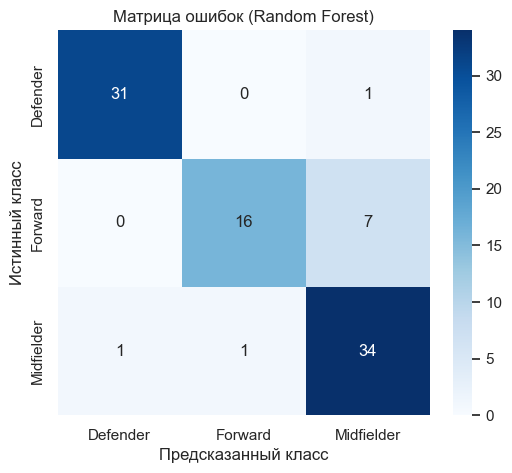

/var/folders/bk/q_qwgy714tg3lldg65372szr0000gn/T/ipykernel_31062/3803321089.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature', palette='viridis')


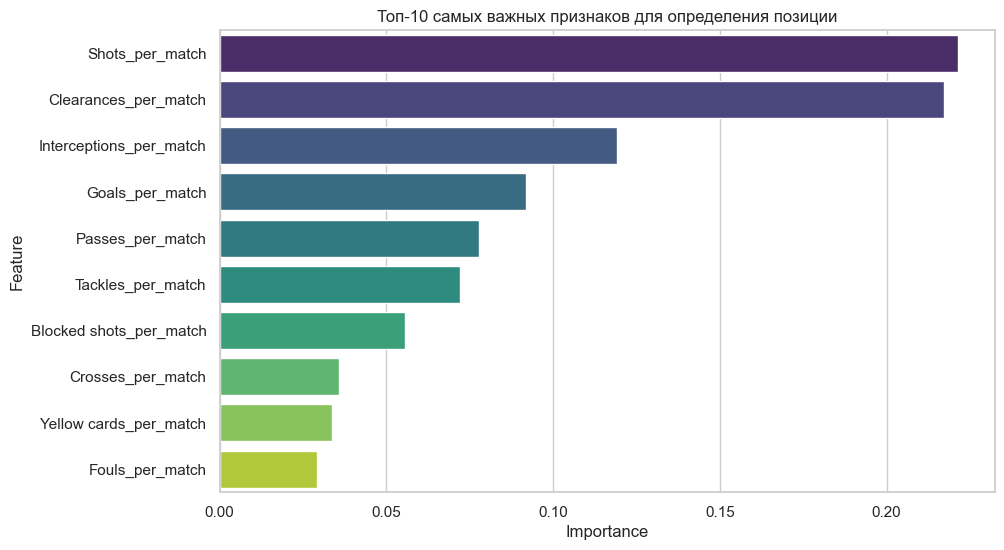

In [40]:
# 1. Матрица ошибок (Confusion Matrix)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Матрица ошибок (Random Forest)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# 2. Анализ важности признаков (Feature Importance) [cite: 51]
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Топ-10 самых важных признаков для определения позиции')
plt.show()

In [41]:
# Находим игроков, на которых модель ошиблась
X_test_with_info = df_model.loc[X_test.index].copy()
X_test_with_info['True_Position'] = le.inverse_transform(y_test)
X_test_with_info['Predicted_Position'] = le.inverse_transform(y_pred_rf)

# Фильтруем только ошибки
errors = X_test_with_info[X_test_with_info['True_Position'] != X_test_with_info['Predicted_Position']]

print(f"Всего ошибок: {len(errors)} из {len(y_test)} тестовых примеров.")
print("\nПримеры неправильно классифицированных игроков:")
display(errors[['Name', 'True_Position', 'Predicted_Position', 'Goals_per_match', 'Tackles_per_match']].head(10))

# Текстовый вывод для анализа (вставьте это в Markdown ячейку в конце):
"""
АНАЛИЗ ОШИБОК:
Мы видим, что модель часто путает полузащитников (Midfielder) и защитников (Defender).
Причина: В современном футболе опорные полузащитники (CDM) имеют статистику, очень похожую на защитников 
(много отборов, мало голов).
Пример: Если игрок X является полузащитником, но делает 2.5 отбора за матч, модель считает его защитником.

Ограничения модели:
Модель опирается только на статистику действий, но не знает зоны на поле. 
Для улучшения можно было бы добавить тепловые карты (Heatmaps), но это визуальные данные, запрещенные в задании.
"""

Всего ошибок: 10 из 91 тестовых примеров.

Примеры неправильно классифицированных игроков:


,Name,True_Position,Predicted_Position,Goals_per_match,Tackles_per_match
26,Reiss Nelson,Forward,Midfielder,0.050000,0.750000
254,Rodrigo Moreno,Forward,Midfielder,0.052632,0.789474
545,Jarrod Bowen,Forward,Midfielder,0.045455,1.090909
25,Nicolas Pépé,Forward,Midfielder,0.151515,0.969697
41,Kortney Hause,Defender,Midfielder,0.055556,1.166667
404,Joelinton,Forward,Midfielder,0.050000,0.900000
285,Fousseni Diabaté,Forward,Midfielder,0.000000,0.733333
161,Jeffrey Schlupp,Midfielder,Defender,0.074324,1.878378
451,Stuart Armstrong,Midfielder,Forward,0.133333,1.016667
486,Lucas Moura,Forward,Midfielder,0.186667,1.266667


'\nАНАЛИЗ ОШИБОК:\nМы видим, что модель часто путает полузащитников (Midfielder) и защитников (Defender).\nПричина: В современном футболе опорные полузащитники (CDM) имеют статистику, очень похожую на защитников \n(много отборов, мало голов).\nПример: Если игрок X является полузащитником, но делает 2.5 отбора за матч, модель считает его защитником.\n\nОграничения модели:\nМодель опирается только на статистику действий, но не знает зоны на поле. \nДля улучшения можно было бы добавить тепловые карты (Heatmaps), но это визуальные данные, запрещенные в задании.\n'